<a href="https://colab.research.google.com/github/tom2rd/Googlecolabutils/blob/master/science/fdtd_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## 各ライブラリのインポート

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as Path
import matplotlib.patches as patches
from matplotlib import cm
from scipy import signal
from scipy.stats import norm

### 媒質の特性
* 大気密度$\rho$と音速$C$と体積弾性率$\kappa$の３つのパラメータを用いる
* それぞれの関係は次式で表される

\begin{equation}
C = \sqrt{\frac{\kappa}{\rho}} \\
(C:音速{\rm [m/s]}, \rho: 大気密度{\rm [kg/m^3]}, \kappa: 体積弾性率{\rm [Pa]([kg/ms^2])})
\end{equation}

* 常温付近の音速と温度の関係

\begin{equation}
C = 331.5 + 0.60t \\
(t: 温度[{}^\circ C])
\end{equation}

*  傾き(0.60)は温度によって変化(0${}^\circ$Cで0.607)し，切片(331.5)は比熱，大気圧，媒質密度によって変化 \\

* 大気密度は温度，大気圧から次式によって求められる
\begin{equation}
\rho = \frac{1.293P}{1+t/273.15} \\
(P: 大気圧[{\rm atm}])
\end{equation}

In [0]:
temperature = 15 
atm = 1.013 
C = 331.5 + 0.60 * temperature 

Ro = (1.293 * atm)/(1+(temperature/273.15))  
K=Ro*C*C

print("sound velocity: "+str(C)+" [m/s]")
print("atmosphere density: " +str(round(Ro, 3))+ " [kg/m^3]")
print("bulk module: " +str(round(K, 0))+ " [Pa]")

sound velocity: 340.5 [m/s]
atmosphere density: 1.242 [kg/m^3]
bulk module: 143954.0 [Pa]


## パラメータの設定
### CFL条件とシミュレーション空間設定
* Courant-Friedrichs-Lewy Condition
* 情報を伝播させる速さが実際の音が伝わる速さより遅くならないようにするための条件
* 情報が伝播する速さは空間分解能を時間分解能を割った時の商，音の伝わる速さは音速になる
\begin{equation}
\frac{\Delta x}{\Delta t}>C
\end{equation}
* 空間的に細かく追跡する場合は時間幅を狭くする必要があるため所望する時間までの計算時間が増加


In [0]:
# space discrete width [1/m]
dx = 0.01
dy = dx

# time discrete width [1/s]
dt = 0.00001

# sampling rate [Hz]
fs = 1/dt
print("sampling rate: " + str(round(fs)) + " [Hz]")

# position of a sound source
sx = 0.3
sy = 0.4

# position of a sound receiving point
mx = 1.0
my = 1.0

# number of calculation
time = 2000
sec = time*dt
print("calclate time: " + str(round(sec, 6)) + " [sec]")

# CFL condition
if dx/dt > C:
    print("CFL condition: OK ")
else :
    print("CFL condition: NG")

sampling rate: 100000 [Hz]
calclate time: 0.02 [sec]
CFL condition: OK 


### 吸音率をもとにした音響インピーダンス設定
*  境界面上における音圧を$p$，粒子速度を$u$，そのときのノーマル音響インピーダンス$Z$は次式によって表される
* 材料表面における音圧と表面に垂直な粒子速度成分の比
\begin{equation}
Z = \frac{p}{u}
\end{equation}

* 吸音材料に角度$\theta$で音が入射したときのノーマル音響インピーダンス$Z_n$
\begin{equation}
Z_n = \frac{\rho c}{{\rm cos}\theta}\cdot\frac{p_i+p_o}{p_i-p_o}
\end{equation}


In [0]:
# 音響インピーダンス設定
ab = 0.00001 # 吸音率
Z = Ro*C*((1 + np.sqrt(1-ab)) / (1 - np.sqrt(1-ab)))

## 室形状設定
以下の7つの室形状から一つ選択してから，境界インデックスの生成をする

### 矩形室（4 [m] × 3 [m]）(1/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-2, -1.5], # left, bottom
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 79:CLOSEPOLY

### 下辺が「く」（4 [m] × 3 [m]）(2/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-2, -1.5], # left, bottom
    [0, 0],   # KU point
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 3:CURVETO 79:CLOSEPOLY

### 下辺が曲面（4 [m] × 3 [m]）(3/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-2, -1.5], # left, bottom
    [0, 1.0],   # curve point
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 3, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 3:CURVETO 79:CLOSEPOLY

### 左辺がギザギザ（4 [m] × 3 [m]）(4/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-1.75, 1.25],
    [-2, 1.0],
    [-1.75, 0.75],
    [-2, 0.5],
    [-1.75, 0.25],
    [-2, 0],
    [-1.75, -0.25],
    [-2, -0.5],
    [-1.75, -0.75],
    [-2, -1],
    [-1.75, -1.25],
    [-2, -1.5],
    [-2, -1.5], # left, bottom
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 3:CURVETO 79:CLOSEPOLY

### 左辺が細かくギザギザ（4 [m] × 3 [m]）(5/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-1.8, 1.375], #
    [-2, 1.25],
    [-1.8, 1.125], #
    [-2, 1.0],
    [-1.8, 0.875], #
    [-2, 0.75],
    [-1.8, 0.625], #
    [-2, 0.5],
    [-1.8, 0.375], #
    [-2, 0.25],
    [-1.8, 0.125], #
    [-2, 0.0],
    [-1.8, -0.125], #
    [-2, -0.25],
    [-1.8, -0.375], #
    [-2, -0.5],
    [-1.8, -0.625], #
    [-2, -0.75],
    [-1.8, -0.875], #
    [-2, -1.0],
    [-1.8, -1.125], #
    [-2, -1.25],
    [-1.8, -1.375], #
    [-2, -1.5],
    [-2, -1.5], # left, bottom
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 79])

### 矩形室（4 [m] × 3 [m]）+ 突起 (6/7)

In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-2, -1.5], # left, bottom
    [-0.1, -1.5], # wall, left, bottom
    [-0.1, -0.5], # wall, left, top
    [0.1, -0.5], # wall, right, top
    [0.1, -1.5], # wall ,right, bottom
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 2, 2, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 79:CLOSEPOLY

### 矩形室（4 [m] × 3 [m]）+ 大きめの突起 (7/7)


In [0]:
verts = np.array([
    [-2,  1.5], # left, top
    [-2, -1.5], # left, bottom
    [-0.1, -1.5], # wall, left, bottom
    [-0.1, 1.0], # wall, left, top
    [0.1, 1.0], # wall, right, top
    [0.1, -1.5], # wall ,right, bottom
    [ 2, -1.5], # right, bottom
    [ 2,  1.5], # right, top
    [-2,  1.5]  # return to start point
    ])
codes = np.array([1, 2, 2, 2, 2, 2, 2, 2, 79]) # 1:MOVETO, 2:LINETO, 79:CLOSEPOLY

### 室形状表示

In [0]:
pth = Path.Path(verts, codes)
patch = patches.PathPatch(pth, facecolor='none', lw=2, ls='--')
plt.gca().add_patch(patch)
plt.xlim(-3,3)
plt.ylim(-2,2)
plt.axis('equal')
plt.show()

### 境界インデックス生成

1. 頂点の最大値を取得
1. 最小値から最大値の間を空間解像度幅で分割した数列を作成
1. ↑で求めた数列の長さを使って矩形のグリッドを生成
1. ↑のグリッドのすべての座標にて内外の境界を判別，記録

In [0]:
# 1 obtain max(min) value
pth = Path.Path(verts, codes)
x_min = min(verts[:,0])
x_max = max(verts[:,0])
y_min = min(verts[:,1])
y_max = max(verts[:,1])

# 2 generate target rectangle area
x = np.arange(x_min+0.5*dx, x_max+0.5*dx, dx)
y = np.arange(y_min+0.5*dy, y_max+0.5*dy, dy)

X = len(x)
Y = len(y)

bools = np.zeros((X,Y), dtype="bool")

# 3 generate boundary list
for j in range(Y):
    points = [[x[i], y[j]] for i in range(X)]
    bools[:,j] = pth.contains_points(points)

# 4 determine the boundaries inside and outside
boundary_x_in = []
boundary_x_out = []
for i in range(X-1):
    for j in range(Y):
        if(bools[i,j] == 0 and bools[i+1,j] == 1):
            boundary_x_in.append([i+1,j])
        elif(bools[i,j] == 1 and bools[i+1,j] == 0):
            boundary_x_out.append([i,j])
boundary_x_in = np.array(boundary_x_in)
boundary_x_out = np.array(boundary_x_out)

boundary_y_in = []
boundary_y_out = []
for i in range(X):
    for j in range(Y-1):
        if(bools[i,j] == 0 and bools[i,j+1] == 1):
            boundary_y_in.append([i,j+1])
        elif(bools[i,j] == 1 and bools[i,j+1] == 0):
            boundary_y_out.append([i,j])
boundary_y_in = np.array(boundary_y_in)
boundary_y_out = np.array(boundary_y_out)

## 音源の生成
どちらかを実行
### 正弦パルスによる音圧の初期化
* 音響分野でよく用いられるものは数セルにわたってなめらかな分布をもつ初期条件を与える手法

\begin{equation}
  p(r)= \begin{cases}
    0.5+0.5\cos \frac{\pi r}{R} & r\leqq R \\
    0 & r > R
    \end{cases}
\end{equation}

* 急激な変化を伴うもの（インパルス信号など）は解析結果に大きな誤差を与える危険性有り

### 点音源の差分化
* 点音源での音圧を，点音源から放出される体積速度$Q(t)$で表現

\begin{equation}
  \frac{1}{\rho_{0}c^2}\frac{\partial p}{\partial t} =
  -{\rm div}u + \frac{Q(t)}{V}
\end{equation}

* 上式を差分化

\begin{equation}
  p^{n+1} = p^n + \rho_{0}c^2 \frac{Q(n+\frac{1}{2}\Delta t)}{V} \Delta t
\end{equation}

* 体積速度波形$Q(n)$を与えることによって点音源を作成できる
* $Q(n)$にガウシアンパルスを用いた場合，受音点のセルの音圧を観測することによりインパルス応答を得られる
* 以下がガウシアンパルスの式

\begin{equation}
  Q(\tau) = \begin{cases}
    e^{-\alpha(\tau - \tau_{0})^2} & 0 \leqq \tau \leqq 2\tau_{0} \\
    0 & その他
  \end{cases}
\end{equation}

### 正弦パルスを用いた音源の生成 (1/2)

In [0]:
ang = np.arange(-np.pi, np.pi,2.*np.pi/50.)
sig = np.cos(ang)
sig += 1

### ガウス分布を用いた音源の生成 (2/2)

In [0]:
ang = np.arange(-np.pi,np.pi,2.*np.pi/50.)
sig = norm.pdf(ang)
sig *= 4

### 音源の波形と周波数特性

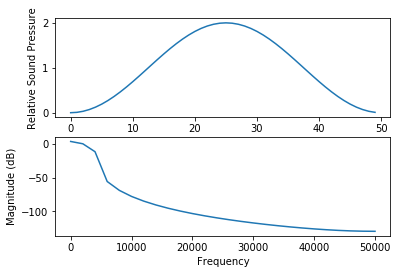

In [0]:
plt.subplot(2,1,1)
plt.plot(sig)
plt.xlabel("Sample")
plt.ylabel("Relative Sound Pressure")

plt.subplot(2,1,2)
plt.magnitude_spectrum(sig, Fs=fs, scale='dB')

plt.show()

## 計算用アレイの定義・初期化

In [0]:
P = np.zeros((X,Y),"float64")

Ux = np.zeros((X+1,Y),"float64")

Uy = np.zeros((X,Y+1),"float64")

# 実行部

## 受音点，音源

In [0]:
micx = (mx - x_min)/dx
micy = (my - y_min)/dy
mic = []

ssx = (sx - x_min)/dx
ssy = (sy - y_min)/dy

## 逐次計算

In [0]:
for t in range(time):
    sys.stdout.flush()
    sys.stdout.write("\r{}".format("calculating: "+str(t+1)+"/"+str(time)))
    if t<len(sig):
        P[int(ssx),int(ssy)] += sig[t]

    Ux[1:X,:]=Ux[1:X,:]-dt/Ro/dx*(P[1:X,:]-P[:X-1,:])  # x軸の粒子速度更新
    Uy[:,1:Y]=Uy[:,1:Y]-dt/Ro/dy*(P[:,1:Y]-P[:,:Y-1])  # y      〃

    A=dt/(Ro*dx)
    # particle velocity at x-axis at boundary
    for n in range(len(boundary_x_in)):
        Ux[boundary_x_in[n,0], boundary_x_in[n,1]] = P[boundary_x_in[n,0], boundary_x_in[n,1]]/-Z
    for n in range(len(boundary_x_out)):
        Ux[boundary_x_out[n,0]+1, boundary_x_out[n,1]] = 0.0
    
    # particle velocity at y-axis at boundary
    for n in range(len(boundary_y_in)):
        Uy[boundary_y_in[n,0], boundary_y_in[n,1]] = 0.0
    for n in range(len(boundary_y_out)):
        Uy[boundary_y_out[n,0], boundary_y_out[n,1]+1] = 0.0

    # updating sound pressure
    P[:X,:Y] = P[:X,:Y]-K*dt/dx*(Ux[1:X+1,:]-Ux[:X,:]) \
                -K*dt/dy*(Uy[:,1:Y+1]-Uy[:,:Y])
    
    if t > 100:
        mic.append(P[int(micx), int(micy)])

calculating: 2000/2000

## 可視化

### 音場

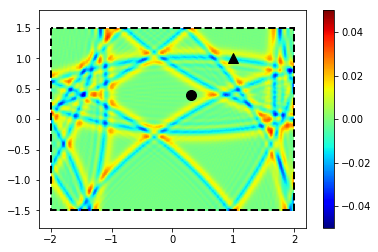

In [0]:
yy, xx = np.meshgrid(y,x)
plt.pcolor(xx, yy, P, cmap=cm.jet)

patch = patches.PathPatch(pth, facecolor='none', lw=2, ls='--')
plt.gca().add_patch(patch)
plt.axis('equal')
plt.clim(-0.05, 0.05)
plt.colorbar()
plt.plot(sx, sy, 'o', lw=2, color='black', ms=10)
plt.plot(mx, my, '^', lw=2, color='black', ms=10)
plt.show()

### マイクロホン位置での音圧

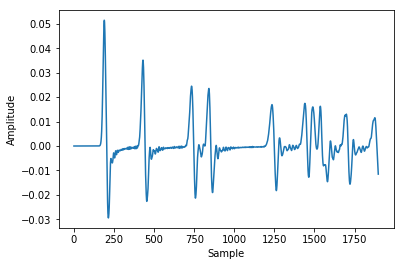

In [0]:
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.plot(mic);

# license information



OpenAcoustics: The Open Source Collection for Computational Acoustics

               Copyright (C) 2008-2016 The OpenAcoustics Team

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License along
    with this program; if not, write to the Free Software Foundation, Inc.,
    51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Change Log
fdtd_notebook.ipynb  

The format is based on [Keep a Changelog](https://keepachangelog.com/en/1.0.0/),  
and this project adheres to [Semantic Versioning](https://semver.org/spec/v2.0.0.html).

## [Unreleased]

## [0.0.1] - 2019-06-03

### Added

- some variations of room shape 
- a variation of sound source (like a gaussian pulse)
- some description about FDTD method
- license.txt

### Changed

- converted python 2 to 3 (.ipynb)